In [59]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from keras.models import Sequential
from keras.layers import Dense
import os
import cv2


from keras.utils import to_categorical #to create dummy variable
from keras.layers import Conv2D,Flatten,Dropout, MaxPooling2D,AveragePooling2D

import import_ipynb
import utils

In [60]:
# SOME IMPORTANT GLOBAL VARIABLE
labels = ["Bedroom","Coast","Forest","HighWay","Industrial","InsideCity","Kitchen","LivingRoom","Mountain","Office","OpenCountry","Store","Street","Suburb","TallBuilding"]
train_dir = '../images/train/'
test_dir = '../images/test/'


In [70]:
#creation of  initial data
#train data
list_of_images = utils.list_of_path(labels,train_dir)
train_data,train_labels= utils.read_and_process_images(list_of_images)

#test data
list_of_images_test = utils.list_of_path(labels,test_dir)
test_data,test_labels = utils.read_and_process_images(list_of_images_test)


# DATA AUGMENTATION 

In order to try to achieve a better result, first of all we will try to augment our available data by performing a left-to-right tranformation; in this way we will double our available data 

In [71]:
# augmented train data 
train_data_aug,train_labels_aug = utils.data_augmentation(train_data,train_labels)
test_data_aug, test_labels_aug = utils.data_augmentation(test_data,test_labels)

In [72]:
# reshape the data in order to make them feasible 
train_data_aug = train_data_aug.reshape(train_data_aug.shape[0],train_data_aug.shape[1],train_data_aug.shape[2],1)
test_data_aug = test_data_aug.reshape(test_data_aug.shape[0],test_data_aug.shape[1],test_data_aug.shape[2],1)

In [73]:
# create one-note-encoding to make labels feasible for the cnn
test_labels_dummy = to_categorical(test_labels,15)
train_labels_dummy_aug = to_categorical(train_labels_aug,15)
test_labels_dummy_aug = to_categorical(test_labels_aug,15)

# CREATION OF THE CNN 

FIrstly we will try to simply apply the same cnn that we build in the previus part of the exercise and see how the solution gets improved (remember: test_accuracy~0.33)

In [11]:
from keras.utils import to_categorical
from keras import optimizers
from keras import initializers
sgd = optimizers.SGD(momentum=0.9,nesterov=True)
norm = initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)

In [ ]:
#adam = optimizers.Adam()
model = Sequential()
#first convolutional layer
model.add(Conv2D(filters=8,kernel_size=3,padding = 'valid',activation='relu',input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=2,strides=2))

#secondo convolutional layer
model.add(Conv2D(filters=16,kernel_size=3,strides=2,padding='valid',activation='relu',input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=2,strides=2))

#third convolutional layer
model.add(Conv2D(filters=32,kernel_size=3,padding='valid',activation='relu',input_shape=(64,64,1)))
model.add(Flatten())
model.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
model.add(Dense(15,activation='softmax'))

#classification output
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics = ['accuracy'])




In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import History
history = History()
earlyStopping = EarlyStopping(min_delta=0.10,patience = 10)


model.fit(train_data_aug,train_labels_dummy_aug,batch_size=32,epochs=100,validation_split=0.15,shuffle=True,callbacks=[earlyStopping,history])


In [ ]:
model.evaluate(test_data_aug,test_labels_dummy_aug)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

plt.title("validation loss")
plt.xlabel("epochs")
plt.ylabel("log-loss")
ax1.plot(history.history['val_loss'])


plt.title("validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
ax2.plot(history.history['val_accuracy'])

plt.title(" accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
ax3.plot(history.history['accuracy'])

plt.title("Log-loss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
ax4.plot(history.history['loss'])

In [ ]:
 c = model.predict_proba(test_data_aug)

In [ ]:
from keras.utils import plot_model
print("My Custom CNN Network:")
plot_model(model, to_file='custom-cnn.png', show_shapes=True, show_layer_names=True)

## OBSERVATION 

Only with the augmentation of data, we reach a better results in terms of test accuracy (we pass fro 0.33 to 0.44): what to do now? We can try to perform:

-BatchNormalization

-Add Dropout

-Change structure of the CNN, for example by introducing convolutional layer or by changing the size of filters


Our aim is to reach a results better than 0.60

In [9]:
from keras.layers.normalization import BatchNormalization

In [14]:
## CNN in which I add 2 dropout layer  and I add batch normalization at the end of every layer and I also add a learning parameter  
#ho cambiato l'optimizer e il learning rate
sgd_2 = optimizers.SGD(momentum=0.9,nesterov=True,decay = 1e-6, lr = 0.01)
adam = optimizers.Adam()
model_2 = Sequential()
#first convolutional layer
model_2.add(Conv2D(filters=8,kernel_size=3,padding = 'valid',activation='relu',input_shape=(64,64,1)))
model_2.add(BatchNormalization(axis = 1))
model_2.add(MaxPooling2D(pool_size=2,strides=2))
model_2.add(Dropout(0.3))

#secondo convolutional layer
model_2.add(Conv2D(filters=16,kernel_size=3,strides=2,padding='valid',activation='relu',input_shape=(64,64,1)))
model_2.add(BatchNormalization(axis = 1))
model_2.add(MaxPooling2D(pool_size=2,strides=2))
model_2.add(Dropout(0.3))

#third convolutional layer
model_2.add(Conv2D(filters=32,kernel_size=3,padding='valid',activation='relu',input_shape=(64,64,1)))
model_2.add(Flatten())
model_2.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
model_2.add(BatchNormalization(axis = 1))
model_2.add(Dense(15,activation='softmax'))

#classification output
model_2.compile(loss='categorical_crossentropy',optimizer= adam,metrics = ['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import History
history_2 = History()
earlyStopping_2 = EarlyStopping(min_delta=0.10,patience = 10)


c = model_2.fit(train_data_aug,train_labels_dummy_aug,batch_size=32,epochs=100,validation_split=0.15,shuffle=True,callbacks=[earlyStopping_2,history_2])


In [ ]:
score = model_2.evaluate(test_data_aug,test_labels_dummy_aug)

In [ ]:
score

# Play with numbers of convolutional layers


-Try to add another convolutional layers!


In [74]:
np.random.seed(9)
model_3 = Sequential()
#first convolutional layer
model_3.add(Conv2D(filters=8,kernel_size=(3,3),strides = 1,padding = 'valid',activation='relu',input_shape=(64,64,1)))
model_3.add(BatchNormalization(axis=1))
model_3.add(MaxPooling2D(pool_size=2,strides=2))
model_3.add(Dropout(0.3))

#secondo convolutional layer
model_3.add(Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=(64,64,1)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=2,strides=2))
model_3.add(Dropout(0.3))
#third convolutional layer
model_3.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,1)))
model_3.add(Flatten())
model_3.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
model_3.add(BatchNormalization())
model_3.add(Dense(15,activation='softmax'))

#classification output
model_3.compile(loss='categorical_crossentropy',optimizer= adam,metrics = ['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import History
history_3 = History()
earlyStopping_3 = EarlyStopping(min_delta=0.10,patience = 10)


model_3.fit(train_data_aug,train_labels_dummy_aug,batch_size=32,epochs=100,validation_split=0.15,shuffle=True,callbacks=[earlyStopping_3,history_3])


In [76]:
model_3.evaluate(test_data_aug,test_labels_dummy_aug)

5970/5970 [==============================] - 9s 1ms/step


[2.1920820164321055, 0.492797315120697]

In [ ]:
from keras.utils import plot_model
plot_model(model_3,show_shapes=True, show_layer_names=True)

In [54]:
def cnn():
    model = Sequential()
    #first convolutional layer
    model.add(Conv2D(filters=8,kernel_size=(3,3),padding = 'valid',activation='relu',input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,strides=2))
    model.add(Dropout(0.3))

    #secondo convolutional layer
    model.add(Conv2D(filters=16,kernel_size=(3,3),strides=2,padding='valid',activation='relu',input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,strides=2))
    model.add(Dropout(0.3))
    
    #third convolutional layer
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,1)))
    
    model.add(Flatten())
    model.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Dense(15,activation='softmax'))

    #classification output
    model.compile(loss='categorical_crossentropy',optimizer= adam,metrics = ['accuracy'])
    return model


    




def ensemble_of_network(mod,iteration,train_data, train_labels,test_data):
    history = History()
    earlyStopping = EarlyStopping(min_delta=0.10,patience = 10)
    prediction = np.zeros((test_data.shape[0],15))
    for i in range(iteration):
        model_2 = mod()
        model_2.fit(train_data,train_labels,batch_size=32,epochs=100,validation_split=0.15,shuffle=True,callbacks=[earlyStopping,history])
        prediction = prediction + model.predict_proba(test_data)
    prediction = prediction/iteration 
    return prediction
    
        
def calculate_accuracy(prediction,test_labels):
    total = test_labels.shape[0]
    cont = 0
    for i in range(len(prediction)):
        if(np.argmax(prediction[i])==test_labels[i]):
            cont = cont + 1
        else: 
            continue 
    res = cont/total
    return res    
        
    

In [ ]:
prova = ensemble_of_network(cnn,10,train_data_aug,train_labels_dummy_aug,test_data_aug)


In [31]:
c = calculate_accuracy(prova,test_labels_aug)

In [51]:
c

0.6108877721943049

In [77]:
np.random.seed(9)
model_4 = Sequential()
#first convolutional layer
model_4.add(Conv2D(filters=8,kernel_size=(3,3),strides = 1,padding = 'valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization(axis=1))
model_4.add(MaxPooling2D(pool_size=2,strides=2))
model_4.add(Dropout(0.3))

#secondo convolutional layer
model_4.add(Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))
#third convolutional layer
model_4.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))


model_4.add(Conv2D(filters=64,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=2,strides=2))
model_4.add(Dropout(0.3))

#for now I just add another maxpooling
model_4.add(Flatten())
model_4.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
model_4.add(BatchNormalization())
model_4.add(Dense(15,activation='softmax'))

#classification output
model_4.compile(loss='categorical_crossentropy',optimizer= adam,metrics = ['accuracy'])

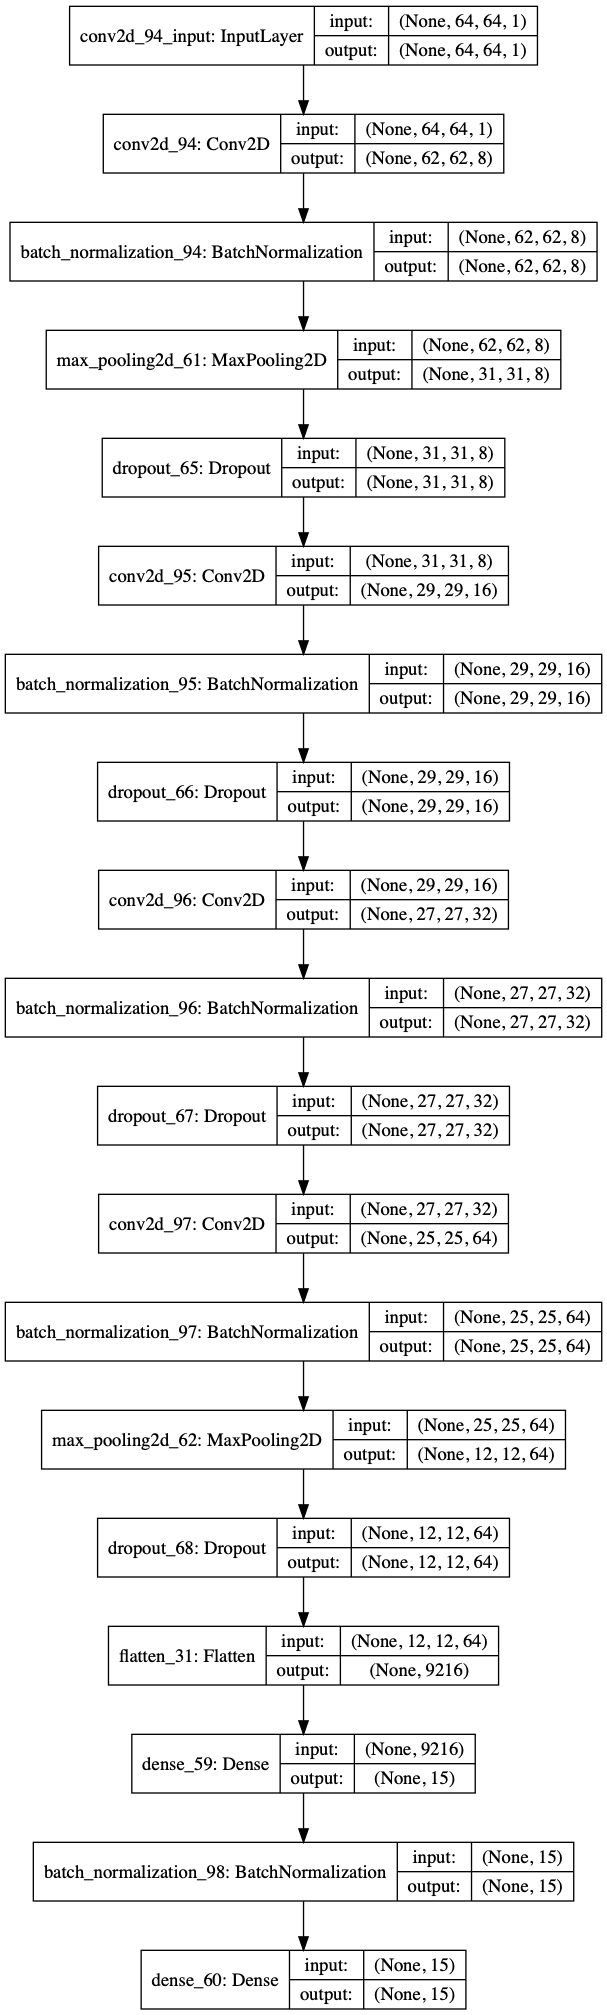

In [78]:
plot_model(model_4,show_shapes=True, show_layer_names=True)